<a href="https://colab.research.google.com/github/WeiningKan/Applied-Spatial-Statistics-Course-Project-Code/blob/main/A6_WeiningKan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 6
**Due date/time:** Apr 19th Fri 23:59pm

**Instruction**: Make a copy of this notebook and read through the questions and instructions. Write down code/text to perform the analysis.

**Submission**: After you finish working on this notebook, click File->Download->Download .ipynb

Please submit a notebook named A6_your_name.ipynb on Canvas.

## Instructions:

In this assignment, I hope to give you the maximum flexibility. You are free to train ANY 1 or several machine learning models on ANY dataset of your choice and to report the results. Here are some specific requirements:

1) Briefly explain how the selected machine learning model(s) work, using 2-3 sentences. (20%)

2) Provide a rationale for choosing this particular machine learning model(s) over others in 2-3 sentences. (20%)

3) Train and test your model(s). (30%)

4) Report the accuracy of your model(s) on both the training and test datasets. (10%)

5) Use simple comments or markdowns to explain your steps and code throughout the notebook. (20%)


Feel free to use the data from your final project for this assignment. Alternatively, if you are still wondering your project data or idea, you are welcome to use either the health data or the election data that we have previously used.

# **How LSTM work?**

Long Short-Term Memory networks (LSTMs) are a special kind of Recurrent Neural Network (RNN) that effectively capture long-term dependencies using a structured memory cell. They regulate the flow of information through gates that decide what to retain in memory and what to discard. This structure allows LSTMs to make predictions based on current input, previous output, and the retained memory state.

#  **The rationale for choosing this particular machine learning model(s) over others.**
The dataset is the daily average of PM2.5 for eleven consecutive years, and the data have distinct time-series characteristics, including seasonal variations and long-term trends.  
LSTM models have inherent advantages for time series prediction because they are able to capture and memorize long-term data dependencies, which are crucial for predicting environmental indicators such as PM2.5. Compared to traditional recurrent neural networks, LSTM's gate control mechanism effectively prevents the problem of vanishing or exploding gradients and ensures the stability of model training on long series.

# **Train and test LSTM.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Python Package
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### **Data Preparation**

**Study area:** Tallahassee  
**Temporal Scope:** Over the six years, from 2010 to 2020  
**Data:** PM2.5 (Particulate Matter)


In [ ]:
# List of all file names
pm_6file = ['daily_88101_2010.csv', 'daily_88101_2011.csv', 'daily_88101_2012.csv', 'daily_88101_2013.csv', 'daily_88101_2014.csv','daily_88101_2015.csv', 'daily_88101_2016.csv', 'daily_88101_2017.csv', 'daily_88101_2018.csv', 'daily_88101_2019.csv', 'daily_88101_2020.csv']

# Empty DataFrame to store all data
all_data_pm = pd.DataFrame()

# Loop to read and merge data
for file_name in pm_6file:
    file_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/GIS5122_Final/PM2.5', file_name)
    df = pd.read_csv(file_path)
    all_data_pm = pd.concat([all_data_pm, df])

# Convert date column to datetime object
all_data_pm['Date Local'] = pd.to_datetime(all_data_pm['Date Local'])

# Replace spaces in column names with underscores
all_data_pm.columns = all_data_pm.columns.str.replace(' ', '_')

# Filter data for State Name 'Florida' and Sample Duration '24 HOUR'
pm_tally = all_data_pm[(all_data_pm['City_Name'] == 'Tallahassee') & (all_data_pm['Sample_Duration'] == '24 HOUR')]

<ipython-input-4-cf7f50646a38>:10: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
<ipython-input-4-cf7f50646a38>:10: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
<ipython-input-4-cf7f50646a38>:10: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
<ipython-input-4-cf7f50646a38>:10: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [ ]:
pm_tally

,State_Code,County_Code,Site_Num,Parameter_Code,POC,Latitude,Longitude,Datum,Parameter_Name,Sample_Duration,...,AQI,Method_Code,Method_Name,Local_Site_Name,Address,State_Name,County_Name,City_Name,CBSA_Name,Date_of_Last_Change
57527,12,73,12,88101.0,1.0,30.439722,-84.346389,WGS84,PM2.5 - Local Conditions,24 HOUR,...,19.0,118.0,R & P Model 2025 PM2.5 Sequential w/WINS - GRA...,Tallahassee Community College,110 CENTURY PARK CIRCLE WEST,Florida,Leon,Tallahassee,"Tallahassee, FL",2021-11-08
57528,12,73,12,88101.0,1.0,30.439722,-84.346389,WGS84,PM2.5 - Local Conditions,24 HOUR,...,33.0,118.0,R & P Model 2025 PM2.5 Sequential w/WINS - GRA...,Tallahassee Community College,110 CENTURY PARK CIRCLE WEST,Florida,Leon,Tallahassee,"Tallahassee, FL",2021-11-08
57529,12,73,12,88101.0,1.0,30.439722,-84.346389,WGS84,PM2.5 - Local Conditions,24 HOUR,...,27.0,118.0,R & P Model 2025 PM2.5 Sequential w/WINS - GRA...,Tallahassee Community College,110 CENTURY PARK CIRCLE WEST,Florida,Leon,Tallahassee,"Tallahassee, FL",2021-11-08
57530,12,73,12,88101.0,1.0,30.439722,-84.346389,WGS84,PM2.5 - Local Conditions,24 HOUR,...,45.0,118.0,R & P Model 2025 PM2.5 Sequential w/WINS - GRA...,Tallahassee Community College,110 CENTURY PARK CIRCLE WEST,Florida,Leon,Tallahassee,"Tallahassee, FL",2021-11-08
57531,12,73,12,88101.0,1.0,30.439722,-84.346389,WGS84,PM2.5 - Local Conditions,24 HOUR,...,74.0,118.0,R & P Model 2025 PM2.5 Sequential w/WINS - GRA...,Tallahassee Community College,110 CENTURY PARK CIRCLE WEST,Florida,Leon,Tallahassee,"Tallahassee, FL",2021-11-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127073,12,73,12,88101.0,2.0,30.439722,-84.346389,WGS84,PM2.5 - Local Conditions,24 HOUR,...,21.0,145.0,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Tallahassee Community College,110 CENTURY PARK CIRCLE WEST,Florida,Leon,Tallahassee,"Tallahassee, FL",2021-10-31
127074,12,73,12,88101.0,2.0,30.439722,-84.346389,WGS84,PM2.5 - Local Conditions,24 HOUR,...,34.0,145.0,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Tallahassee Community College,110 CENTURY PARK CIRCLE WEST,Florida,Leon,Tallahassee,"Tallahassee, FL",2021-10-31
127075,12,73,12,88101.0,2.0,30.439722,-84.346389,WGS84,PM2.5 - Local Conditions,24 HOUR,...,26.0,145.0,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Tallahassee Community College,110 CENTURY PARK CIRCLE WEST,Florida,Leon,Tallahassee,"Tallahassee, FL",2021-10-31
127076,12,73,12,88101.0,2.0,30.439722,-84.346389,WGS84,PM2.5 - Local Conditions,24 HOUR,...,22.0,145.0,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Tallahassee Community College,110 CENTURY PARK CIRCLE WEST,Florida,Leon,Tallahassee,"Tallahassee, FL",2021-10-31


### **Data preprocessing for LSTM**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Assuming the first column in your features will be your label
features = pm_tally[['Arithmetic_Mean']]
target = pm_tally[['Arithmetic_Mean']]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)
target_normalized = scaler.fit_transform(target)

n_past_steps = 7  # Number of past timesteps you want to use for prediction

# A helper function to prepare data with shifted sequences
def create_sequences(data, n_past_steps):
    X, y = [], []
    for i in range(n_past_steps, len(data)):
        X.append(data[i-n_past_steps:i, :])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, n_past_steps)

In [ ]:
X.shape

(1278, 7, 1)

In [ ]:
y.shape

(1278,)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, random_split

# Splitting dataset into training and testing sets
split = int(0.8 * len(X))  # 80% for training, 20% for testing

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
X_train_tensor = torch.Tensor(X_train)  # Convert features to a torch Tensor
y_train_tensor = torch.Tensor(y_train)  # Convert labels to a torch Tensor
X_test_tensor = torch.Tensor(X_test)  # Convert features to a torch Tensor
y_test_tensor = torch.Tensor(y_test)  # Convert labels to a torch Tensor

# Create a TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### **Define the LSTM model**

In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(SimpleLSTM, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        #create your LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        #After LSTM to a linear prediction to get the predicted value
        self.linear = nn.Linear(hidden_size, 1)


    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        #Go through your LSTM
        out, (hh,cc) = self.lstm(x, (h0, c0))

        # Get the last time stamp prediction from LSTM
        out = self.linear(out[:, -1, :])
        return out

Initialize the model

In [ ]:
model = SimpleLSTM(input_size=X.shape[-1], hidden_size=32, num_layers=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train the model

In [ ]:
%%time

train_losses = []
val_losses = []

#Number of epochs
#With 150 epochs, I found the model overfitted.
epochs = 30
for epoch in tqdm(range(epochs)):
    #turn on training mode
    model.train()
    train_loss = 0
    #For each batch in our training dataset
    for X_batch, y_batch in train_loader:
        #reset gradients
        optimizer.zero_grad()
        #forward to get prediction
        y_pred = model(X_batch)
        #calculate loss
        loss = criterion(y_pred, y_batch)
        #backward to update weights/biases
        loss.backward()
        optimizer.step()
        #sum over loss for all the batches.
        train_loss += loss.item()

    #store the average loss
    train_losses.append(train_loss / len(train_loader))


    #turn on evaluation mode
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            #forward to get predicton
            y_pred = model(X_batch)
            #calculate loss on test data
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
    #store the average loss
    val_losses.append(val_loss / len(test_loader))


  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 30/30 [00:06<00:00,  4.38it/s]

CPU times: user 4.53 s, sys: 75.2 ms, total: 4.6 s
Wall time: 6.87 s


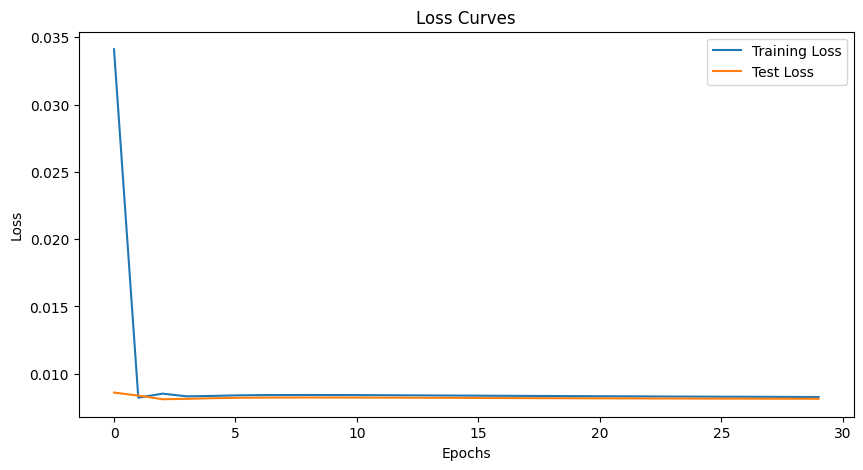

In [ ]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Test Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.xlim(0,200)
#plt.ylim(0,0.04)
plt.legend()
plt.show()

Get prediction for both training data and test data to evaluate performance

In [ ]:
model.eval()  # Set the model to evaluation mode
predictions = []
actuals = []

with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        # Store predictions and actual values
        predictions.extend(outputs.view(-1).tolist())

        actuals.extend(labels.view(-1).tolist())

    for inputs, labels in test_loader:
        outputs = model(inputs)
        # Store predictions and actual values
        predictions.extend(outputs.view(-1).tolist())

        actuals.extend(labels.view(-1).tolist())

#Inverse transform the predictions and actuals
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).reshape(-1)
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).reshape(-1)

Plot the predicted daily arithmetic mean of PM 2.5, before the blue line are the training data, and after the blue line is the testing data.

Text(0.5, 1.0, 'Figure 1')

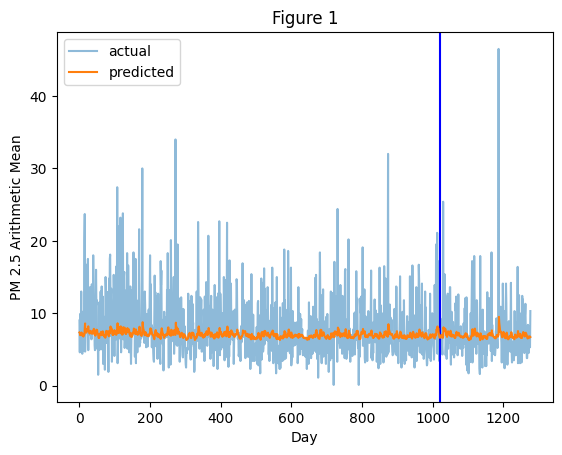

In [ ]:
plt.plot(actuals,label="actual",alpha=0.5)
plt.axvline(x = split, color = 'b')
plt.plot(predictions,label="predicted")
plt.xlabel('Day')
plt.ylabel('PM 2.5 Arithmetic Mean')
plt.legend()
plt.title('Figure 1')

# **Report the accuracy of LSTM on both the training and test datasets.**

**MAE of 2.8394:** An average deviation of 2.8394µg/m³ from the actuals.

**MSE of 14.9495:** Higher MSEs indicate larger errors in some predictions, with the significant overprediction for days 750-800 shown in Figure 1 (predicted values are 35µg/m³ higher than actual values).

**RMSE of 3.8665:** The RMSE being around 3.8665 units signifies that the model's predictions are, on average, nearly 3.8665µg/m³ off from the actual values.

From the above values as well as Figure 1, the performance of the model is likely to be satisfactory for rough estimation. However, for applications that require high accuracy, such as providing health advice based on air quality data, or environmental regulations that may require industrial facilities or local governments to maintain PM2.5 below a certain standard to avoid fines or other legal consequences. The model may require further optimization of the model, an increase in the variety and quality of data inputs, or the application of more sophisticated analytical techniques.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
#MAE
mae = mean_absolute_error(actuals, predictions)

#MSE
mse = mean_squared_error(actuals, predictions)

#RMSE
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 2.891515349947697
MSE: 17.750334487266667
RMSE: 4.213114582736466
